# Clustering using NSM
Demonstrating clustering using non-negative similarity matching.

In [1]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch import nn

from pynsm import SimilarityMatching

## Generate a dataset using a mixture of Gaussians
First generate samples for each cluster.

In [2]:
torch.manual_seed(0)

input_dim = 50

n_clusters = 5
n_samples_each = 10_000
samples0 = []

sample_ids = []

for i in range(n_clusters):
    mu = 2.5 * torch.randn(input_dim)
    gauss = torch.distributions.multivariate_normal.MultivariateNormal(
        mu, torch.eye(input_dim)
    )
    crt_samples = gauss.sample(sample_shape=(n_samples_each,))

    samples0.append(crt_samples)
    sample_ids.extend(n_samples_each * [i])

n_samples = n_clusters * n_samples_each
sample_ids = torch.tensor(sample_ids)

Shuffle the samples so the ones belonging to the same clusters are no longer grouped together.

In [3]:
perm = torch.randperm(n_samples)
samples = torch.vstack((samples0))[perm]
sample_ids = sample_ids[perm]

Visualize the dataset.

Text(0, 0.5, 'dim 1')

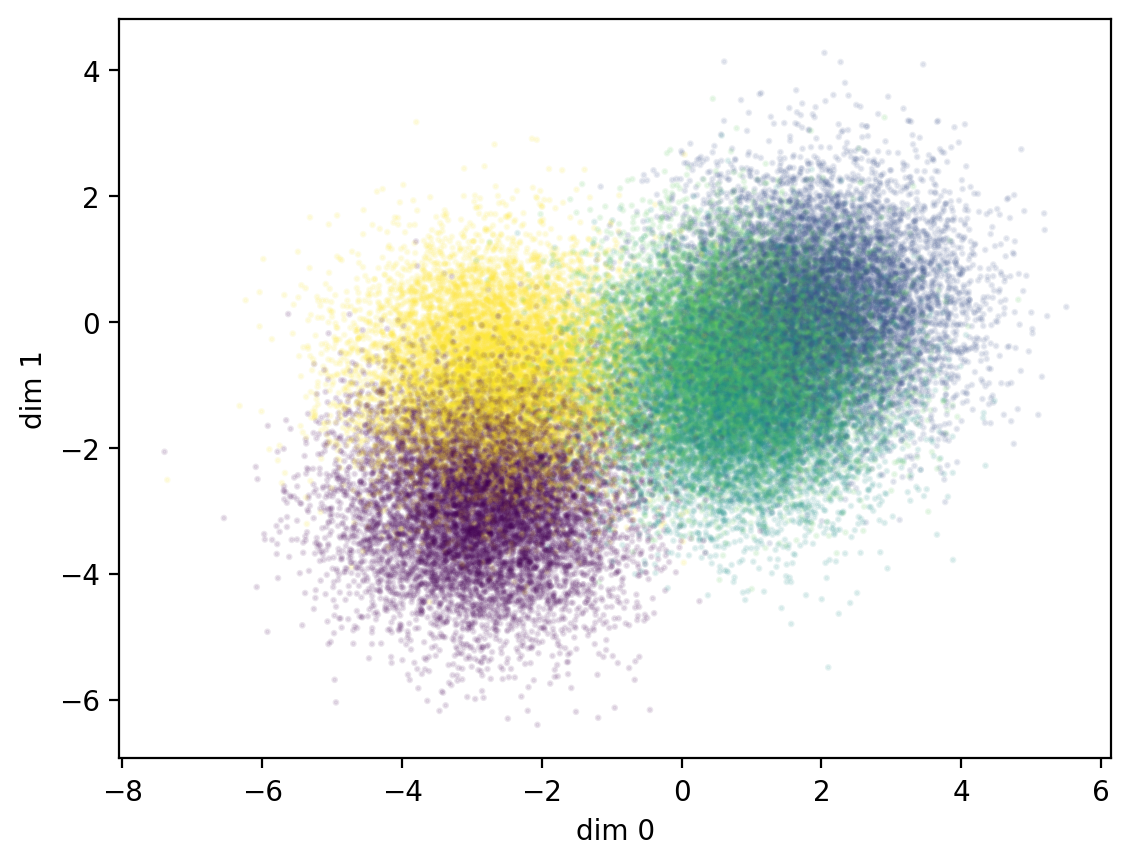

In [4]:
_, ax = plt.subplots()
ax.scatter(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    s=2,
    c=sample_ids.numpy(),
    alpha=0.1,
)
ax.set_xlabel("dim 0")
ax.set_ylabel("dim 1")

## Train NSM

In [5]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

encoder = nn.Linear(input_dim, n_clusters)
model = SimilarityMatching(
    encoder,
    out_channels=n_clusters,
    iteration_projection=nn.ReLU(),
    max_iterations=20,
    tau=0.5,
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

t0 = time.time()
running_loss = []
outputs = []
pbar = tqdm(samples)
for sample in pbar:
    sample = sample[None, ...].to(device)

    output = model(sample)
    loss = model.loss(sample, output)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
    outputs.append(output.detach().cpu())

    pbar.set_postfix({"loss": running_loss[-1]}, refresh=False)

t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds.")

Running on cpu.


100%|██████████| 50000/50000 [00:58<00:00, 858.14it/s, loss=-112]   

Training took 58.28 seconds.


Show learning curve.

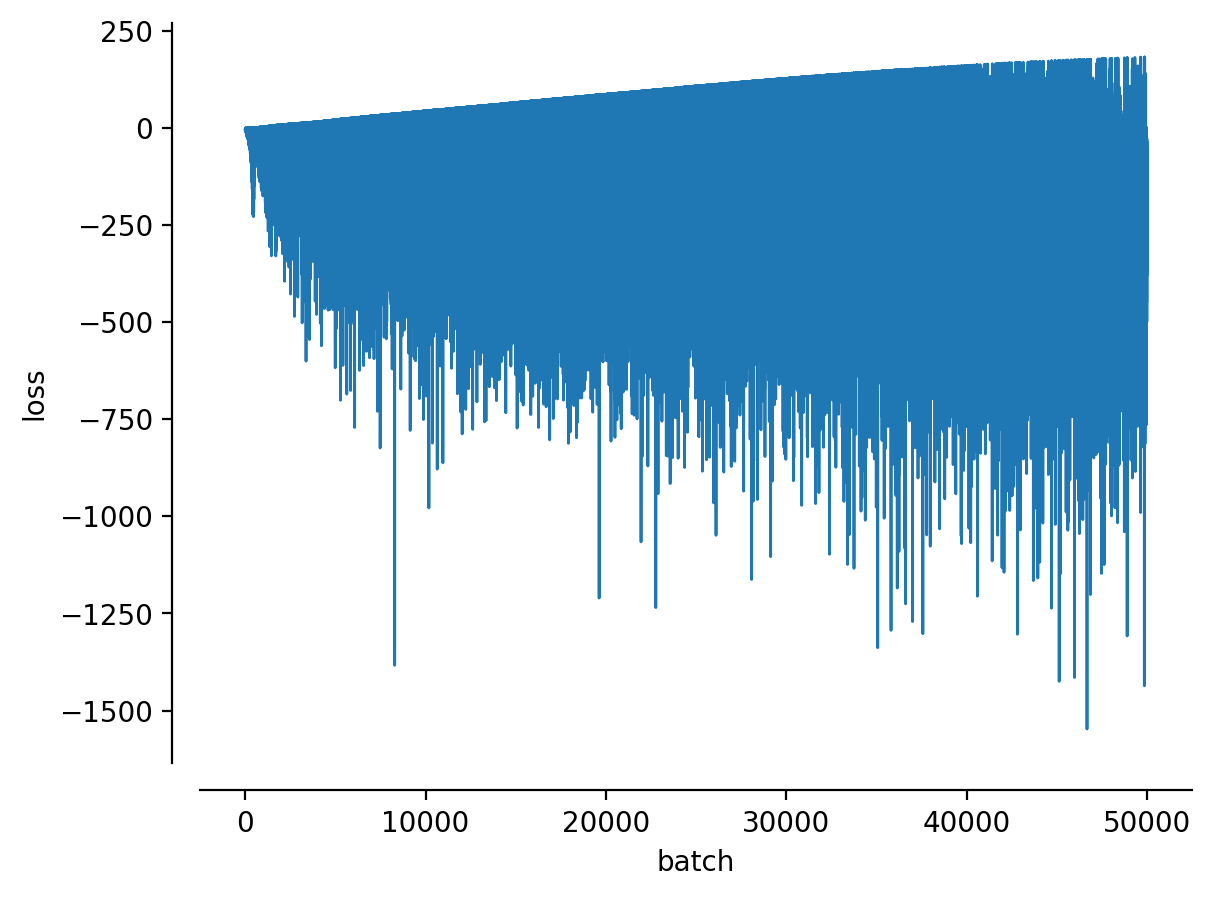

In [6]:
fig, ax = plt.subplots()
ax.plot(running_loss, lw=1.0)
ax.set_xlabel("batch")
ax.set_ylabel("loss")
sns.despine(ax=ax, offset=10)

Visualize the clustering output.

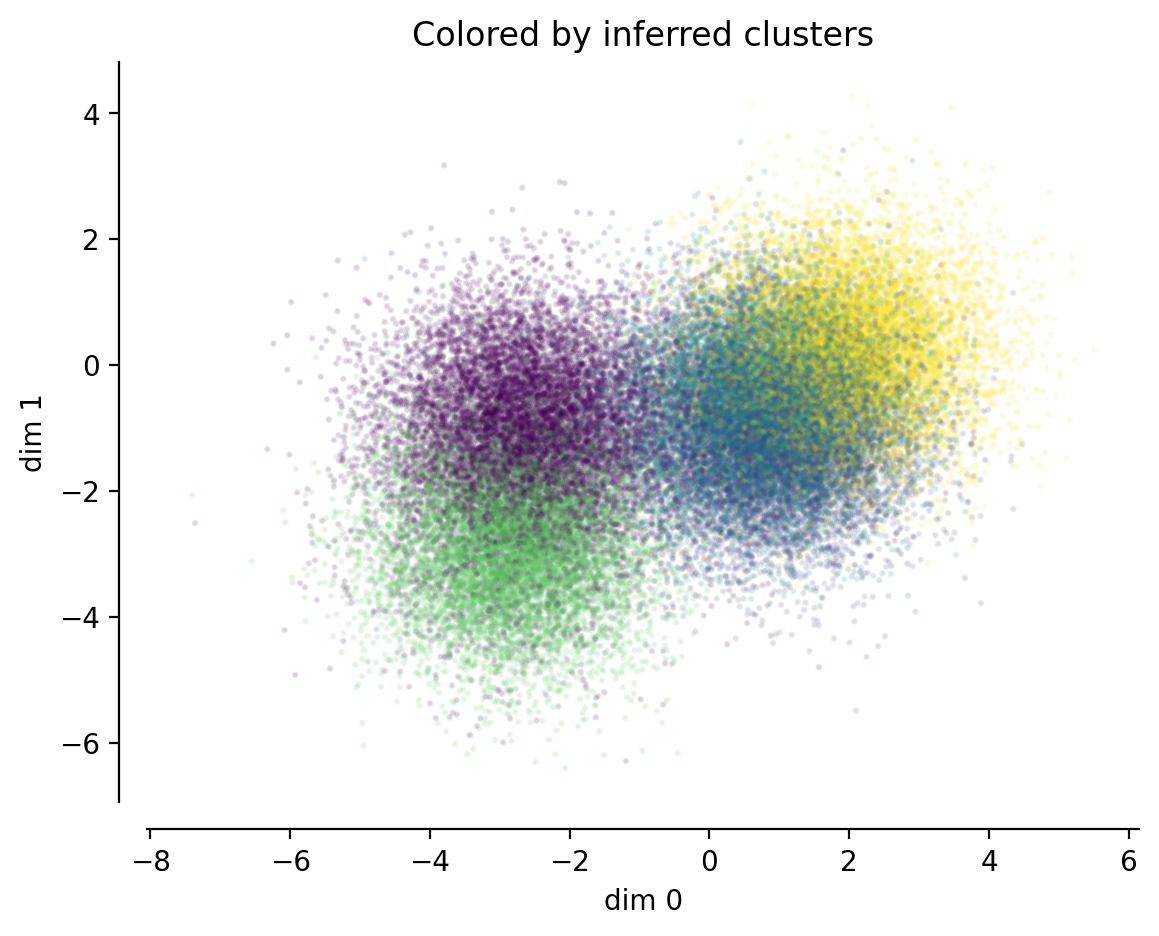

In [7]:
cluster_assignments = np.argmax(np.asarray(outputs).squeeze(), axis=1)
_, ax = plt.subplots()
ax.scatter(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    s=2,
    c=cluster_assignments,
    alpha=0.1,
)
ax.set_xlabel("dim 0")
ax.set_ylabel("dim 1")
ax.set_title("Colored by inferred clusters")
sns.despine(ax=ax, offset=10)

Show a confusion matrix to check clustering accuracy.

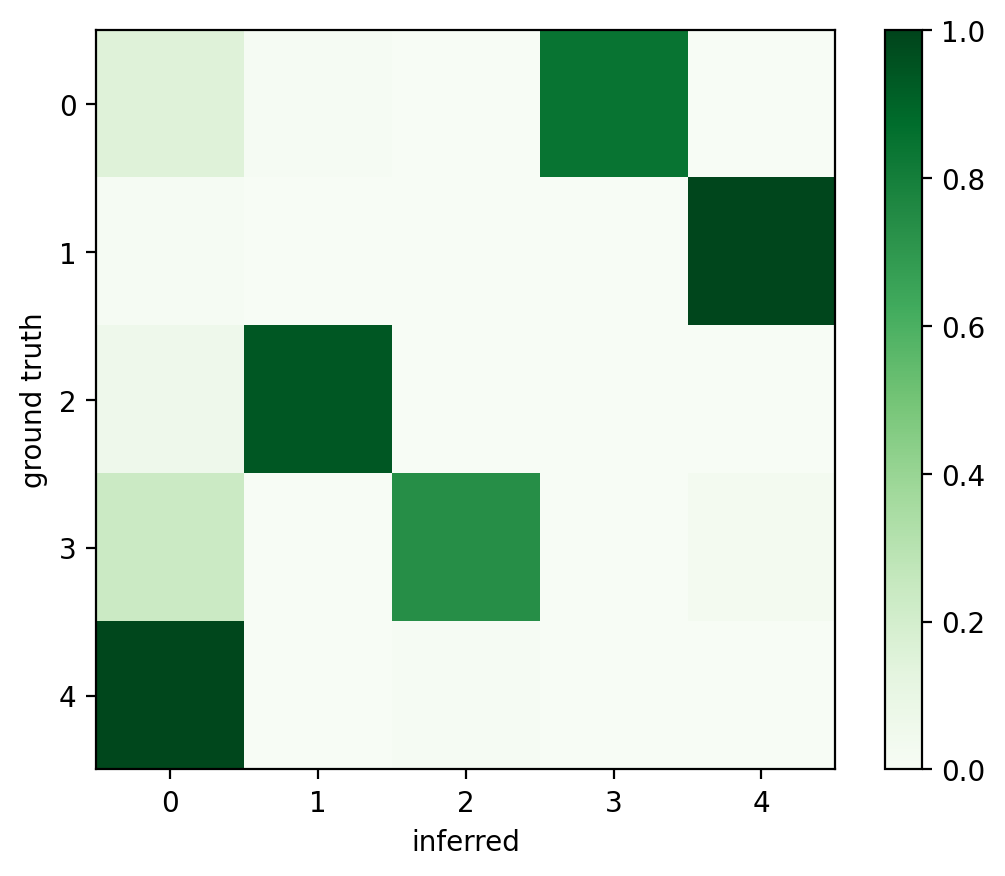

In [8]:
confusion = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    selection_gt = sample_ids.numpy() == i
    n_gt = np.sum(selection_gt)
    for j in range(n_clusters):
        selection_assigned = cluster_assignments == j

        confusion[i, j] = np.sum(selection_gt & selection_assigned) / n_gt

_, ax = plt.subplots()
h = ax.imshow(confusion, vmin=0, vmax=1, cmap="Greens")
ax.set_xlabel("inferred")
ax.set_ylabel("ground truth")
plt.colorbar(h)